# Setup

In [64]:
# Pandas and numpy necessary to do basic data cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 7(a) - Common Trends in Linear vs. Log

In [150]:
N = 2   # Sample size
T = 15  # Time periods

In [159]:
np.random.seed(5882300)

# Choose cohorts
cohort = np.array([8,50])
ids    = np.tile(np.arange(1,N+1),T)
time   = np.repeat(np.arange(1,T+1),N)

# Combine people into dataset 
cdf = pd.DataFrame({'id':np.arange(1,N+1),'cohort':cohort})
df  = pd.DataFrame({'id':ids,'time':time})
df  = df.merge(cdf, on='id', how='inner')

# Add relative time and treatment indicator
df['rel'] = df.time-df.cohort
df['D']   = (df.rel >= 0).astype(int)

# Add random person fixed effects and linear time trend.
t_fe    = np.arange(1,T+1)
i_fe    = np.random.uniform(size=N)*5.0
t_fe_df = pd.DataFrame({'time':np.arange(1,T+1),'t_fe':t_fe})
i_fe_df = pd.DataFrame({'id':np.arange(1,N+1),'i_fe':i_fe})
df      = df.merge(t_fe_df, on='time', how='inner')
df      = df.merge(i_fe_df, on='id', how='inner')

# Shut down random noise for this one 
df['u0']  = 0.0
df['u1']  = 0.0

# Specify ATT and potential outcomes model
df['att'] = 1.0
df['y0']  = df.t_fe + df.i_fe + df.u0
df['y1']  = df.t_fe + df.i_fe + att + df.u1
df['y']   = df.D*(df.y1) + (1.0-df.D)*(df.y0)

#Take logs
df['ln_y0'] = np.log(df.y0)
df['ln_y1'] = np.log(df.y1)
df['ln_y']  = np.log(df.y)

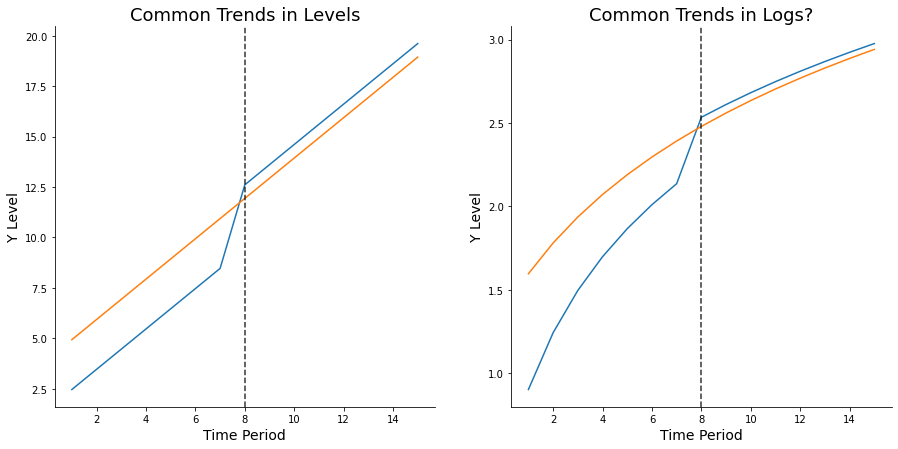

In [170]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax     = ax.flatten()

# Formatting stuff
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Plot 1 main stuff
ax[0].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'y'])
ax[0].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'y'])
ax[1].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'ln_y'])
ax[1].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'ln_y'])

# Vertical/horizontal lines
ax[0].axvline(x=8, color='black', linestyle='dashed', alpha=0.8)
ax[1].axvline(x=8, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax[0].set_xlabel("Time Period", size=14)
ax[0].set_ylabel("Y Level", size=14)
ax[1].set_xlabel("Time Period", size=14)
ax[1].set_ylabel("Y Level", size=14)

# Titles
ax[0].set_title("Common Trends in Levels", size=18)
ax[1].set_title("Common Trends in Logs?", size=18)

# Save out
plt.savefig("./q7_output/q7a.png")
plt.show()

# 7(b)

In [189]:
N = 300  # Sample size
T = 30   # Time periods

In [190]:
np.random.seed(5882300)

# Choose cohorts
cohort = np.concatenate((np.repeat(5,150), np.repeat(9,100), np.repeat(22,50)))
ids    = np.tile(np.arange(1,N+1),T)
time   = np.repeat(np.arange(1,T+1),N)

# Combine people into dataset 
cdf = pd.DataFrame({'id':np.arange(1,N+1),'cohort':cohort})
df  = pd.DataFrame({'id':ids,'time':time})
df  = df.merge(cdf, on='id', how='inner')

# Add relative time and treatment indicator
df['rel'] = df.time-df.cohort
df['D']   = (df.rel >= 0).astype(int)

# Add random person fixed effects and linear time trend.
t_fe    = np.arange(1,T+1)
i_fe    = np.random.uniform(size=N)*5.0
t_fe_df = pd.DataFrame({'time':np.arange(1,T+1),'t_fe':t_fe})
i_fe_df = pd.DataFrame({'id':np.arange(1,N+1),'i_fe':i_fe})
df      = df.merge(t_fe_df, on='time', how='inner')
df      = df.merge(i_fe_df, on='id', how='inner')

# Random noise
df['u0']  = np.random.normal(size=N*T)
df['u1']  = np.random.normal(size=N*T)

# Specify ATT and potential outcomes model
df['att'] = 3.0
df['y0']  = df.t_fe + df.i_fe + df.u0
df['y1']  = df.t_fe + df.i_fe + att + df.u1
df['y']   = df.D*(df.y1) + (1.0-df.D)*(df.y0)

In [191]:
# Average by cohort
agg_df = df.groupby(['cohort','time']).mean().reset_index()

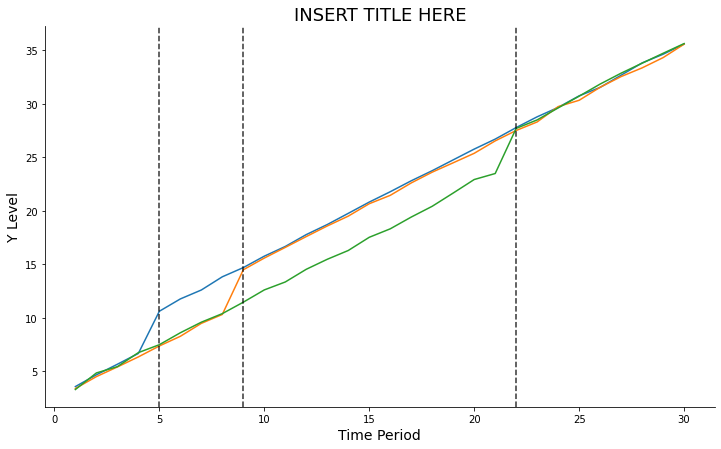

In [195]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(agg_df.loc[agg_df.cohort == 5, 'time'], agg_df.loc[agg_df.cohort == 5, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 9, 'time'], agg_df.loc[agg_df.cohort == 9, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 22, 'time'], agg_df.loc[agg_df.cohort == 22, 'y'])

# Vertical/horizontal lines
ax.axvline(x=5, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=9, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=22, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax.set_xlabel("Time Period", size=14)
ax.set_ylabel("Y Level", size=14)

# Titles
ax.set_title("INSERT TITLE HERE", size=18)

# Save out
plt.savefig("./q7_output/q7b.png")
plt.show()

# 7(c)